In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread('data/train/1/17.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
thresh_type = cv2.THRESH_BINARY_INV
bin_img = cv2.adaptiveThreshold(blur, 255, adapt_type, thresh_type, 11, 2)

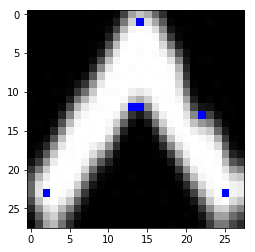

In [17]:
filename = 'data/train/1/15.jpeg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.001*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
# img[res[:,3],res[:,2]] = [0,255,0]

# cv2.imwrite('subpixel5.png',img)
plt.imshow(img)